## Задание 2.1
### Повторить эксперимент с предобучением моделей RBM и без предобучения (рисунок 3 из статьи).
#### Бишук Антон Юрьевич, М05-104

In [11]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

from tqdm.notebook import tqdm

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

In [57]:
class RBM(nn.Module):
    def __init__(self,
                 n_vis=784,
                 n_hin=500,
                 k=5,
                 n_class=10):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
        self.clf = nn.Linear(n_hin, n_class)
    
    def sample_from_p(self,p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v, self.W, self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
    def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
    def forward(self,v, is_clf=False):

        if is_clf == False:
            pre_h1,h1 = self.v_to_h(v)
            
            h_ = h1
            for _ in range(self.k):
                pre_v_,v_ = self.h_to_v(h_)
                pre_h_,h_ = self.v_to_h(v_)
            
            return v,v_
        else:
            v_ = v
            for _ in range(self.k - 1):
                pre_h_,h_ = self.v_to_h(v_)
                pre_v_,v_ = self.h_to_v(h_)
                
            pre_h_,h_ = self.v_to_h(v_)
            
            return self.clf(pre_h_) 

    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

In [58]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

### Посмотрим на то, как работает просто модель RBM

In [59]:
rbm = RBM(k=3)

In [60]:
train_op = optim.SGD(rbm.parameters(),0.1)

for epoch in tqdm(range(10)):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.item())
        train_op.zero_grad()
        loss.backward()
        train_op.step()
    
    print(np.mean(loss_))

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-6.5479403741832485
-6.231876316355236
-3.9998112660227045
-2.569036097414712
-1.7815447646671776
-1.07383513298116
-0.6501352924273721
-0.3402774054358509
-0.0950427024857576
0.12233530788787647


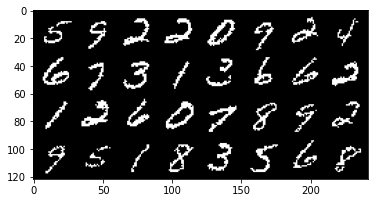

In [61]:
show_adn_save("real",make_grid(v.view(32,1,28,28).data))

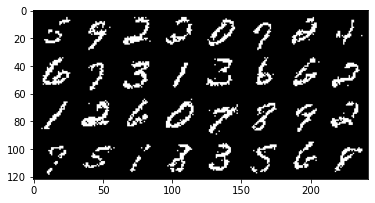

In [62]:
show_adn_save("generate",make_grid(v1.view(32,1,28,28).data))

### Вывод:
Видим, что модель генерирует неплохие семплы

---

### Будем использовать RBM как классификатор без предобученных слоев

In [75]:
rbm = RBM(k=3)

In [76]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rbm.parameters(), lr=0.1)

plot_loss_classic = []
for epoch in tqdm(range(20)):
    loss_ = []
    rbm.train()

    for _, (data, target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        outputs = rbm(sample_data, True)
        loss = criterion(outputs, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    rbm.eval()
    with torch.no_grad():
        for _, (data, target) in enumerate(test_loader):
            data = Variable(data.view(-1,784))
            sample_data = data.bernoulli()
            
            outputs = rbm(sample_data, True)
            loss = criterion(outputs, target)
            loss_.append(loss.item())

    print(np.mean(loss_))
    plot_loss_classic.append(np.mean(loss_))

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


2.3109518919780756
2.3038118280422917
2.2958548387904076
2.270886079520936
2.246816045919042
2.23548389088576
2.2223039478253406
2.2194266319274902
2.206253420775104
2.1965830219779043
2.1935445897898096
2.19442091018531
2.182967626365127
2.1846789083663065
2.1788761714461504
2.180553552451407
2.177198187560792
2.183689316366888
2.171651221384668
2.1678953884513517


---

### Предобучим на генерации, а затем дообучим на классификации RBM

In [65]:
rbm = RBM(k=3)

In [66]:
train_op = optim.SGD(rbm.parameters(),0.1)

for epoch in tqdm(range(10)):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.item())
        train_op.zero_grad()
        loss.backward()
        train_op.step()
    
    print(np.mean(loss_))

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-6.415551500788121
-6.23288591787505
-4.070520331864672
-2.6306574319217253
-1.7598049920250867
-1.1416998499237907
-0.6857566914832922
-0.34577795488239604
-0.08000264442297442
0.07727720996718417


In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rbm.parameters(), lr=0.1)

plot_loss_pretrain = []
for epoch in tqdm(range(10)):
    loss_ = []
    rbm.train()

    for _, (data, target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        outputs = rbm(sample_data, True)
        loss = criterion(outputs, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    rbm.eval()
    with torch.no_grad():
        for _, (data, target) in enumerate(test_loader):
            data = Variable(data.view(-1,784))
            sample_data = data.bernoulli()
            
            outputs = rbm(sample_data, True)
            loss = criterion(outputs, target)
            loss_.append(loss.item())

    print(np.mean(loss_))
    plot_loss_pretrain.append(np.mean(loss_))

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.28320172155026796
0.2469211955121748
0.22901927068188882
0.2137996483072164
0.20579746532236126
0.20095036190098067
0.19099659954381595
0.1853816449274398
0.1855684698316132
0.1793703127498175


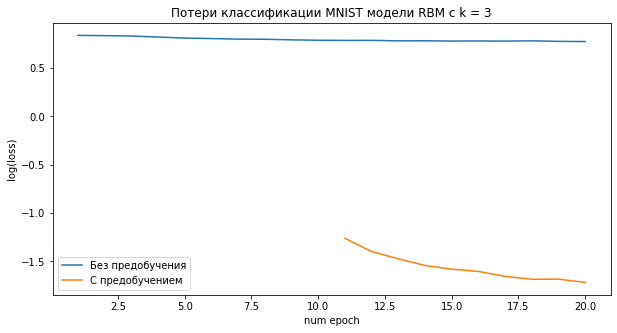

In [82]:
plt.figure(figsize=(10,5))
plt.plot(range(1,21), np.log(plot_loss_classic), label='Без предобучения')
plt.plot(range(11,21), np.log(plot_loss_pretrain), label='C предобучением')
plt.title('Потери классификации MNIST модели RBM c k = 3')
plt.xlabel('num epoch')
plt.ylabel('log(loss)')
plt.legend()

### Вывод:
Видим ту же картину, которая была описана в статье -- даже на старте обучения лосс с предобученными весами меньше, чем у задачи классификации через 10 итераций. Кроме того сам темп уменьшения лосса меньше у решения с предобученной моделью.